# TÉCNICAS DE PROCESAMIENTO DIGITAL DE IMÁGENES

## Proyecto integrador

**Profesor**: Matias Barreto

**Alumnas**: Marianela Miguel, Elisabeth Pose

**Carrera**: Tec. en Ciencia de datos e IA

**Año** : 2025

# Definición del Problema

**Detección automática de postura corporal en tiempo real usando Visión por Computadora**

**Área**: Salud y bienestar.

**Problema**: Muchas personas adoptan posturas incorrectas al trabajar frente a la computadora o entrenar, lo que puede derivar en dolor de cuello, espalda o lesiones.

**Objetivo**:

Desarrollar un sistema en tiempo real capaz de:

1.   Detectar postura corporal (correcta o incorrecta)
2.   Retroalimentar al usuario mediante voz.
3.   Registrar imágenes etiquetadas automáticamente.
4.   Entrenar una red neuronal CNN personalizada para validar la clasificación.





# Diseño de la  Solución

**Herramientas utilizadas**:
Python y Google Colab.

**Librerías**:

OpenCV, NumPy, PIL, matplotlib.

MediaPipe para landmarks del cuerpo.

TensorFlow/Keras para entrenamiento CNN.

Javascript para captura de video y síntesis de voz.

**Proceso general**:


*   Captura de imagen desde la cámara

*   Detección de landmarks corporales con MediaPipe

*   Reglas geométricas simples → Postura correcta/incorrecta.

*   Voz: sintetiza el mensaje para el usuario.

*   Almacena imágenes y etiquetas (frames/ + CSV).

*   Entrenamiento de modelo CNN sobre esas imágenes.

*   Prueba final: inferencia sobre nuevas imágenes.

# implementacion

In [1]:
## Instalación de bibliotecas necesarias
# - mediapipe: librería de Google para la detección de landmarks del cuerpo en tiempo real.
# - opencv-python: procesamiento de imágenes y video (captura, dibujo, manipulación).
!pip install mediapipe opencv-python

In [ ]:
# ✅ IMPORTS NECESARIOS
import cv2
from base64 import b64decode, b64encode
from PIL import Image
import io
from IPython.display import Javascript, display
from google.colab.output import eval_js

In [ ]:


from IPython.display import Javascript, display
from google.colab.output import eval_js

## **El siguiente bloque define una función en Python que carga y ejecuta un script en JavaScript para capturar video desde la cámara del dispositivo en Google Colab.**

# Función para iniciar la captura de video desde la cámara del navegador
 La función video_stream() inyecta un script en JavaScript que:
 - Solicita acceso a la cámara del usuario (modo entorno).
 - Crea una interfaz visual en la notebook (con video en vivo, mensajes y overlay).
 - Permite capturar cuadros (frames) en tiempo real desde el navegador.
 - Muestra un mensaje de estado y una imagen procesada (por ejemplo, con landmarks).
 Además, permite detener la ejecución haciendo clic en el video.
 Este código es esencial para realizar visión por computadora en vivo desde Google Colab.

In [ ]:
# 💻 Código JavaScript embebido en la función `video_stream()`
# Este script se ejecuta en el navegador del usuario y cumple varias funciones clave:
#
# ▶️ 1. Accede a la cámara del dispositivo y muestra el video en tiempo real.
# 🖼 2. Crea una interfaz visual en la notebook que incluye:
#      - Video en vivo (stream)
#      - Imagen procesada con overlay (por ejemplo, los landmarks detectados)
#      - Mensaje de estado (por ejemplo: "Postura correcta")
# 🔄 3. Captura un frame del video y lo convierte en una imagen JPEG codificada en base64.
# 🔊 4. Reproduce un mensaje de voz según el estado de la postura utilizando `speechSynthesis`.
# ❌ 5. Permite al usuario detener el procesamiento haciendo clic en el video o sobre el mensaje.
#
# Esto permite una integración interactiva entre la detección en Python y la interfaz web en Google Colab.

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    var lastSpeechTime = 0;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, captureCanvas.width, captureCanvas.height);
          result = captureCanvas.toDataURL('image/jpeg', 0.8);
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia({ video: { facingMode: "environment" } });
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML = '<span style="color: red; font-weight: bold;">Click en el video para detener</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = video.videoWidth || 640;
      captureCanvas.height = video.videoHeight || 480;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }

    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      stream = await createDom();

      if (label != "") {
        labelElement.innerHTML = label;

        // Voz cada 2 segundos (2000 ms)
        if (Date.now() - lastSpeechTime > 3000) {
          if ('speechSynthesis' in window) {
            var utterance = new SpeechSynthesisUtterance(label);
            utterance.lang = 'es-AR';
            speechSynthesis.cancel();
            speechSynthesis.speak(utterance);
            lastSpeechTime = Date.now();
          }
        }
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {
        'img': result
      };
    }
  ''')
  display(js)

**Procesamiento de video y análisis de postura en tiempo real**

**Este bloque realiza el flujo principal del sistema:**

✅ Captura imágenes en tiempo real desde la cámara del navegador.

✅ Procesa cada frame con MediaPipe para detectar los landmarks corporales.

✅ Evalúa si la postura es correcta o incorrecta según reglas geométricas simples.

✅ Muestra el resultado en pantalla (overlay sobre el video) y también lo anuncia por voz.

✅ Guarda los frames con su etiqueta (correcta o incorrecta) para entrenamiento posterior de una CNN.

✅ Al finalizar, genera un gráfico que muestra la evolución de la postura en el tiempo.


<IPython.core.display.Javascript object>


✅ Postura correcta: 37.14% del tiempo


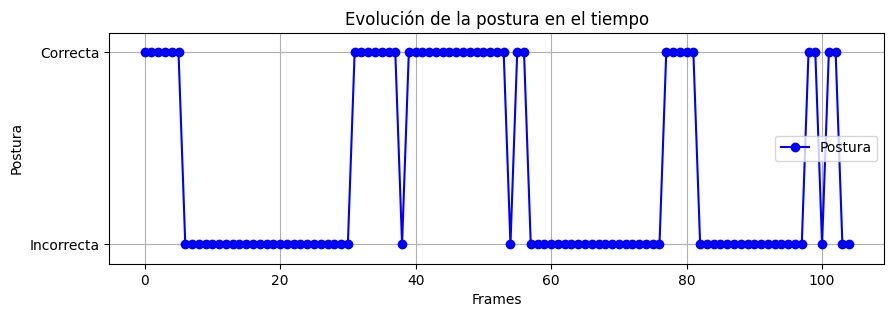

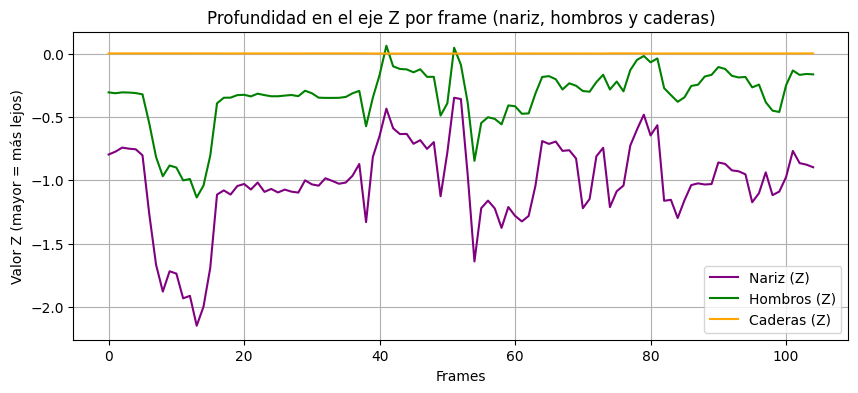

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# === IMPORTACIONES NECESARIAS ===
from base64 import b64decode, b64encode # Para codificar y decodificar datos en base64 (texto a binario y viceversa)
import cv2 # Librería OpenCV para procesamiento de imágenes y visión por computadora
import numpy as np # Para operaciones numéricas y manejo de arrays
from PIL import Image # Para abrir, manipular y convertir imágenes
import io # Para manejar flujos de datos en memoria (por ejemplo, imágenes en bytes)
import mediapipe as mp # Librería de Google para procesamiento de video e inteligencia artificial (pose, manos, rostro, etc.)
import matplotlib.pyplot as plt # Para graficar y visualizar imágenes o datos
import pandas as pd #manipulación y análisis de datos en forma de tablas (DataFrames)
import shutil # permite trabajar con operaciones de archivos y directorios
import math # proporciona funciones matemáticas estándar
import os # permite interactuar con el sistema operativo, como acceder al sistema de archivos, crear carpetas, listar archivos
from google.colab import files #módulo específico de Google Colab que permite subir o descargar archivos entre tu computadora y el entorno de Colab
from datetime import datetime # se utiliza para trabajar con fechas y horas

# === PARÁMETROS DE TOLERANCIA ===
TOLERANCIA_GENERAL = 0.2   # Aumentar para hacerlo más permisivo
TOLERANCIA_Z = 0.7         # Tolerancia para inclinación en z
TOLERANCIA_Z_ADELANTE = 0.7
TOLERANCIA_Z_ATRAS = 0.25
TOLERANCIA_ANGULO_CABEZA_ATRAS = 20

# === FUNCIONES AUXILIARES ===
def js_to_image(js_reply):
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    return cv2.imdecode(jpg_as_np, flags=1)

def bbox_to_bytes(bbox_array):
    bbox_PIL = Image.fromarray(bbox_array, 'RGBA')
    ioBuf = io.BytesIO()
    bbox_PIL.save(ioBuf, format='PNG')
    bbox_bytes = 'data:image/png;base64,{}'.format(
        str(b64encode(ioBuf.getvalue()), 'utf-8')
    )
    return bbox_bytes

def video_frame(label, bbox):
    data = eval_js(f'stream_frame("{label}", "{bbox}")')
    return data

# === INICIALIZACIONES ===
# === Inicializar MediaPipe Pose ===
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.7, min_tracking_confidence=0.7)
mp_drawing = mp.solutions.drawing_utils
# === Iniciar captura desde navegador ===
video_stream()
label_html = 'Analizando postura...'
bbox = ''
count = 0
historial_posturas = []
datos_csv = []

# === CREAR CARPETA UNICA PARA LA SESION ===
timestamp = datetime.now().strftime("%Y_%m_%d_%H%M%S")
sesion_dir = f"sesiones/{timestamp}"
os.makedirs(sesion_dir, exist_ok=True)

# Para graficar valores Z al final
z_nariz = []
z_hombros = []
z_caderas = []

# === BUCLE DE PROCESAMIENTO ===
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    img = js_to_image(js_reply["img"])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    overlay_bgr = np.zeros([img.shape[0], img.shape[1], 3], dtype=np.uint8)

    results = pose.process(img_rgb)
    mensaje = "Postura no detectada"

    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER]
        right_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER]
        left_hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP]
        right_hip = landmarks[mp_pose.PoseLandmark.RIGHT_HIP]
        nose = landmarks[mp_pose.PoseLandmark.NOSE]

        # Promedios
        shoulder_avg_x = (left_shoulder.x + right_shoulder.x) / 2
        shoulder_avg_y = (left_shoulder.y + right_shoulder.y) / 2
        shoulder_avg_z = (left_shoulder.z + right_shoulder.z) / 2
        hip_avg_x = (left_hip.x + right_hip.x) / 2
        hip_avg_y = (left_hip.y + right_hip.y) / 2
        hip_avg_z = (left_hip.z + right_hip.z) / 2

        # === Cálculo de diferencias y alineaciones ===
        horizontal_diff = abs(shoulder_avg_x - hip_avg_x)       # alineación lateral
        vertical_diff = shoulder_avg_y - hip_avg_y              # diferencia de altura hombros vs cadera
        head_forward_x = nose.x - shoulder_avg_x                # cuánto se adelantó la cabeza en X
        head_forward_z = nose.z - shoulder_avg_z                # cuánto se adelantó la cabeza en profundidad (Z)
        torso_forward_z = shoulder_avg_z - hip_avg_z            # inclinación del torso hacia adelante

        # Ángulo entre la cabeza y el torso en el plano Z-X
        angulo_cabeza_zx = math.degrees(math.atan2(head_forward_z, head_forward_x))

        # === Cálculo de inclinación lateral de la cabeza ===
        left_eye = landmarks[mp_pose.PoseLandmark.LEFT_EYE]
        right_eye = landmarks[mp_pose.PoseLandmark.RIGHT_EYE]

        dy = left_eye.y - right_eye.y
        dx = right_eye.x - left_eye.x
        if dx != 0:
            inclinacion_cabeza_rad = abs(np.arctan(dy / dx))
        else:
            inclinacion_cabeza_rad = np.pi / 2  # cabeza muy inclinada (vertical)

        angulo_cabeza_grados = np.degrees(inclinacion_cabeza_rad)
        cabeza_inclinada_lateral = angulo_cabeza_grados > 15  # umbral de inclinación lateral

        # === Reglas para marcar postura incorrecta ===
        torso_inclinado_adelante = torso_forward_z < -TOLERANCIA_Z
        cabeza_muy_adelante = head_forward_z < -TOLERANCIA_Z_ADELANTE
        cabeza_muy_atras = (head_forward_z > TOLERANCIA_Z_ATRAS) or (angulo_cabeza_grados > TOLERANCIA_ANGULO_CABEZA_ATRAS)


        # === Lógica de postura correcta incluyendo inclinación lateral ===
        postura_correcta = (
            horizontal_diff < 0.05 + TOLERANCIA_GENERAL and
            abs(head_forward_x) < 0.05 + TOLERANCIA_GENERAL and
            not torso_inclinado_adelante and
            not cabeza_muy_adelante and
            not cabeza_muy_atras and
            not cabeza_inclinada_lateral
        )

# === Feedback visual y para CSV ===
        nombre_archivo = f"frame_{count:04d}_{'correcta' if postura_correcta else 'incorrecta'}.jpg"
        ruta_archivo = os.path.join(sesion_dir, nombre_archivo) # Use sesion_dir to save images directly to the session folder
        cv2.imwrite(ruta_archivo, img)  # Guardar imagen
        if postura_correcta:
           mensaje = "Postura correcta"
           posture_color = (0, 255, 0)
           historial_posturas.append(1)
          #  datos_csv.append({'frame': count, 'postura_correcta': 1})
        else:
           mensaje = "Postura incorrecta, sientate derecho"
           posture_color = (0, 0, 255)
           historial_posturas.append(0)
          #  datos_csv.append({'frame': count, 'postura_correcta': 0})
        # Guardar nombre de archivo en CSV
        datos_csv.append({'frame': nombre_archivo, 'postura_correcta': int(postura_correcta)})

# === Debug: impresión para calibrar ===
        #print(f"H-diff: {horizontal_diff:.3f}, HeadX: {head_forward_x:.3f}, HeadZ: {head_forward_z:.3f}, TorsoZ: {torso_forward_z:.3f}, Ángulo cabeza: {angulo_cabeza_grados:.1f}°, Atrás?: {cabeza_muy_atras}")

        # Guardar valores Z para graficar luego
        z_nariz.append(nose.z)
        z_hombros.append(shoulder_avg_z)
        z_caderas.append(hip_avg_z)

        # Dibujar landmarks
        mp_drawing.draw_landmarks(
            image=overlay_bgr,
            landmark_list=results.pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=2)
        )

        # Mostrar texto en pantalla
        cv2.putText(
            overlay_bgr, mensaje, (30, 50),
            cv2.FONT_HERSHEY_SIMPLEX, 1.5, posture_color, 3
        )

    else:
        datos_csv.append({'frame': count, 'postura_correcta': -1})

    count += 1

    # Mezclar overlay con imagen original
    overlay_rgba = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGBA)
    img_rgba = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
    alpha_mask = (overlay_rgba[:, :, 0:3] != 0).any(axis=2).astype(np.uint8)
    combined_rgba = img_rgba.copy()
    combined_rgba[alpha_mask == 1] = overlay_rgba[alpha_mask == 1]

    bbox = bbox_to_bytes(combined_rgba)
    label_html = mensaje

# === RESULTADOS Y GRÁFICOS ===
if len(historial_posturas) > 0:
    total = len(historial_posturas)
    correctas = sum(historial_posturas)
    porcentaje_correcta = (correctas / total) * 100
    print(f"\n✅ Postura correcta: {porcentaje_correcta:.2f}% del tiempo")

    # Gráfico binario de postura
    plt.figure(figsize=(10, 3))
    plt.plot(historial_posturas, marker='o', linestyle='-', color='blue', label='Postura')
    plt.ylim(-0.1, 1.1)
    plt.yticks([0, 1], ['Incorrecta', 'Correcta'])
    plt.xlabel('Frames')
    plt.ylabel('Postura')
    plt.title('Evolución de la postura en el tiempo')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfico de valores Z
    plt.figure(figsize=(10, 4))
    plt.plot(z_nariz, label='Nariz (Z)', color='purple')
    plt.plot(z_hombros, label='Hombros (Z)', color='green')
    plt.plot(z_caderas, label='Caderas (Z)', color='orange')
    plt.title("Profundidad en el eje Z por frame (nariz, hombros y caderas)")
    plt.xlabel("Frames")
    plt.ylabel("Valor Z (mayor = más lejos)")
    plt.legend()
    plt.grid(True)
    plt.show()

# === GUARDAR CSV ===
df = pd.DataFrame(datos_csv)
csv_path = os.path.join(sesion_dir, "dataset_postura.csv")
df.to_csv(csv_path, index=False)

# === MOVER LAS IMÁGENES A LA CARPETA DE SESIÓN ===
# Images are already saved to the session directory, so this step is not needed.
# import glob
# for img_path in glob.glob("frames/*.jpg"):
#     shutil.move(img_path, sesion_dir)

# === COMPRIMIR Y DESCARGAR LA SESIÓN ===
zip_base = os.path.join("sesiones", timestamp)
shutil.make_archive(zip_base, 'zip', sesion_dir)
files.download(f"{zip_base}.zip")

*   Detecta la postura en tiempo real con MediaPipe

*   Evalúa si es correcta o no

*   Almacena el historial de cada frame

*   Calcula el porcentaje de tiempo con postura correcta

*   Muestra un gráfico de evolución al final

Luego para entrenar una CNN, creo una carpeta frames/ con:

Imágenes de cada frame etiquetado como correcto (1) o incorrecto (0).

Un CSV llamado dataset_postura.csv.

Un archivo dataset_postura.zip para descargar todo.

# Entrenamiento de una Red Neuronal Convolucional (CNN) - Paso 1: Preparación de los datos

En este bloque se realiza la preparación inicial del dataset:

 🔹 **Se descomprime el archivo ZIP que contiene los frames de las posturas y su CSV de etiquetas**.

 🔹 **Se lee el archivo CSV que vincula cada imagen con su etiqueta (0 = postura incorrecta, 1 = postura correcta)**.

 🔹 **Se asegura que las rutas de las imágenes sean absolutas, para facilitar su uso posterior**.

 🔹 **Se visualiza el dataset con un pequeño preview para verificar que se haya cargado correctamente**.


In [ ]:
import zipfile
import pandas as pd
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# --- 1. Descomprimir el archivo ZIP ---
# zip_path = "/content/dataset_postura.zip"  # Asegurate de que el ZIP esté cargado acá
zip_path = "/content/sesiones/2025_06_26_191405.zip"  # o el nombre real del zip que subiste
extract_path = "/content/sesiones"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

# --- 2. Leer el CSV ---
csv_path = os.path.join(extract_path, "dataset_postura.csv")
df = pd.read_csv(csv_path)

# --- 3. Crear columna con rutas absolutas de las imágenes ---
df["filename"] = df["frame"].apply(lambda x: os.path.join(extract_path, x))

# --- 4. Crear la columna 'label' a partir de 'postura_correcta' ---
df["label"] = df["postura_correcta"].astype(str)  # Necesario para keras

In [ ]:
df.tail(10)

,frame,postura_correcta,filename,label
96,frame_0096_incorrecta.jpg,0,/content/sesiones/frame_0096_incorrecta.jpg,0
97,frame_0097_incorrecta.jpg,0,/content/sesiones/frame_0097_incorrecta.jpg,0
98,frame_0098_incorrecta.jpg,0,/content/sesiones/frame_0098_incorrecta.jpg,0
99,frame_0099_correcta.jpg,1,/content/sesiones/frame_0099_correcta.jpg,1
100,frame_0100_correcta.jpg,1,/content/sesiones/frame_0100_correcta.jpg,1
101,frame_0101_incorrecta.jpg,0,/content/sesiones/frame_0101_incorrecta.jpg,0
102,frame_0102_correcta.jpg,1,/content/sesiones/frame_0102_correcta.jpg,1
103,frame_0103_correcta.jpg,1,/content/sesiones/frame_0103_correcta.jpg,1
104,frame_0104_incorrecta.jpg,0,/content/sesiones/frame_0104_incorrecta.jpg,0
105,frame_0105_incorrecta.jpg,0,/content/sesiones/frame_0105_incorrecta.jpg,0


# Paso 2 – Generadores de Imágenes (Entrenamiento y Validación)

En este bloque se crean generadores que permiten alimentar la red neuronal con imágenes en lotes (batches),
aplicando técnicas de aumento de datos (data augmentation) para mejorar la generalización del modelo.

🔹 Se utiliza ImageDataGenerator para:
     - Reescalar los píxeles al rango [0, 1].
     - Dividir el dataset en un 80% para entrenamiento y un 20% para validación.
    - Aplicar transformaciones aleatorias como giros y espejados horizontales.

🔹 Los generadores leerán directamente desde el DataFrame las imágenes y sus etiquetas.

Esto prepara los datos para ser utilizados por el modelo CNN de forma eficiente.


In [ ]:
# --- 6. Preparar los generadores de entrenamiento y validación ---
# 80 % train – 20 % valid
# Esto crea un generador que además de dividir los datos, aplica transformaciones para aumentar la variedad de imágenes y
# mejorar la generalización del modelo.
datagen = ImageDataGenerator(
    rescale=1./255,          # Normaliza los píxeles (de 0-255 a 0-1)
    validation_split=0.2,    # Separa el 20% de los datos para validación
    horizontal_flip=True,    # Invierte aleatoriamente las imágenes horizontalmente (solo en train)
    rotation_range=5         # Rota aleatoriamente hasta ±5 grados (solo en train)
)
# Este generador va a ir entregando lotes de imágenes y etiquetas del 80% del dataset, aplicando además las transformaciones.
train_gen = datagen.flow_from_dataframe(
    df,                     # DataFrame con nombres de archivos e info de etiquetas
    x_col="filename",       # Columna con las rutas o nombres de las imágenes
    y_col="label",          # Columna con las etiquetas/clases
    target_size=(224, 224), # Redimensiona las imágenes a 224x224 píxeles
    class_mode="binary",    # Porque es una clasificación binaria (dos clases)
    batch_size=32,          # Cantidad de imágenes que se procesan por lote
    subset="training",      # Selecciona el 80% de los datos para entrenamiento
    shuffle=True            # Mezcla los datos aleatoriamente (importante para entrenamiento)
)
#Este generador entrega el 20% restante, sin mezclar ni aplicar transformaciones fuertes (solo el rescale)
val_gen = datagen.flow_from_dataframe(
    df,
    x_col="filename",
    y_col="label",
    target_size=(224, 224),
    class_mode="binary",
    batch_size=32,
    subset="validation",    # Selecciona el 20% de los datos para validación
    shuffle=False           # No mezcla los datos, útil para comparar resultados
)

# --- 7. Crear el modelo CNN con MobileNetV2 ---
base = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base.trainable = False  # Congelamos el modelo base

model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Clasificación binaria
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Found 80 validated image filenames belonging to 2 classes.
Found 20 validated image filenames belonging to 2 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


**Modelo (CNN sencilla o Transfer Learning)**

Opción rápida y potente – MobileNetV2 congelada
¿Qué es MobileNetV2 congelada?
MobileNetV2 es una red neuronal convolucional preentrenada por Google sobre millones de imágenes (ImageNet). Está diseñada para ser liviana y rápida, ideal para aplicaciones en móviles o tiempo real.

"Congelada" significa que no vamos a entrenar sus capas internas (esas ya aprendieron a detectar bordes, formas, texturas, etc.). Solo usaremos su salida como base para que nuestra red aprenda a clasificar "postura correcta" o "incorrecta".

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10  # prueba 10 épocas; ajusta según over/under-fitting
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5917 - loss: 0.9543   

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6062 - loss: 0.9692 - val_accuracy: 0.5000 - val_loss: 1.9988
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6727 - loss: 1.1085 - val_accuracy: 0.5000 - val_loss: 0.6691
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6339 - loss: 0.6907 - val_accuracy: 0.8000 - val_loss: 0.6082
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 943ms/step - accuracy: 0.6242 - loss: 0.6889 - val_accuracy: 0.5000 - val_loss: 0.9296
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 988ms/step - accuracy: 0.6411 - loss: 0.5789 - val_accuracy: 0.5000 - val_loss: 1.0969
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6750 - loss: 0.5637 - val_accuracy: 0.5000 - val_loss: 0.8277
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 990ms/step - accuracy: 0.7245 - loss: 0.4596 - val_accuracy: 0.5000 - val_loss: 0.6670
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 967ms/step - accuracy: 0.6740 - loss: 0.5259 - val_accuracy: 0.5000 - val_loss: 0.6904
Epoch 9/10
3/3

Curvas y evaluación

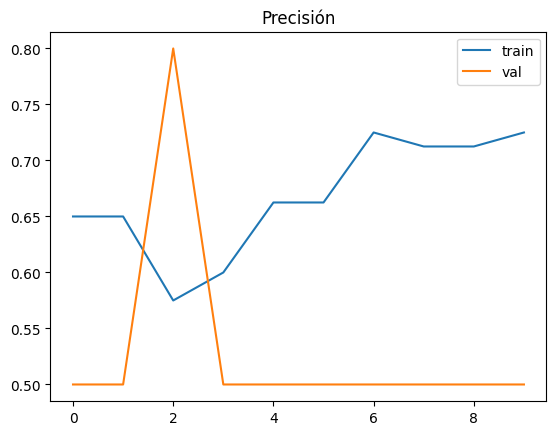

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step - accuracy: 0.5000 - loss: 0.8786
Precisión validación: 50.00%


In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Precisión'); plt.legend(); plt.show()

val_loss, val_acc = model.evaluate(val_gen)
print(f"Precisión validación: {val_acc:.2%}")

**Grafico de lineas que muestra:**

**En azul**: la precisión (accuracy) del modelo sobre los datos de entrenamiento en cada época ('accuracy').

**En naranja**: la precisión sobre el conjunto de validación ('val_accuracy').

El eje x muestra las épocas de entrenamiento (de 0 a 9).

El eje y muestra la precisión (de 0 a 1).

Se observa que la precisión en entrenamiento es buena (cercana a 1), pero la validación fluctúa mucho, incluso baja a 0 en algunos momentos.

**¿Qué indica esto?**

Hay overfitting: el modelo aprende bien los datos de entrenamiento pero no generaliza bien a los datos nuevos.

**La validación es muy baja e inestable, lo que indica que:**

Hay muy pocos datos.

O las clases están desequilibradas o mal etiquetadas.

O el modelo está demasiado complejo para la cantidad de datos que tiene.

In [ ]:
model.save("modelo_postura.h5")

Guardar el modelo **modelo_postura.h5** permite:

Cargar el modelo más adelante con load_model.

Reutilizarlo sin necesidad de volver a entrenar.

Compartirlo o usarlo en producción.

Este código permite reentrenar un modelo de red neuronal previamente entrenado, usando exclusivamente los datos de una nueva sesión de captura de posturas.

🔹 Carga un archivo .zip que contiene imágenes y un archivo CSV con las etiquetas (postura_correcta), y los extrae en una carpeta temporal.

🔹 Prepara los datos, generando rutas completas a cada imagen y convirtiendo las etiquetas a texto para que puedan usarse en el entrenamiento.

🔹 Carga el modelo existente (modelo_postura.h5) y lo recompila para asegurarse de que esté listo para continuar entrenando.

🔹 Configura generadores de imágenes (ImageDataGenerator) que dividen los datos en entrenamiento y validación, aplicando además pequeñas transformaciones como rotaciones e inversión horizontal para aumentar la variedad de datos.

🔹 Entrena el modelo durante 10 épocas con esta nueva información.

🔹 Guarda el modelo actualizado, sobreescribiendo el archivo original con los nuevos pesos aprendidos.

In [ ]:
# === FLUJO PARA REENTRENAR EL MODELO SOLO CON NUEVA SESIÓN ===

import zipfile
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- 1. RUTA AL ZIP DE LA NUEVA SESIÓN ---
zip_path = "/content/sesiones/2025_06_26_191405.zip"  # <- Cambiar si es necesario
extract_path = "/content/posturas_dataset"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

# --- 2. Cargar el CSV y preparar columnas ---
csv_path = os.path.join(extract_path, "dataset_postura.csv")
df = pd.read_csv(csv_path)
df["filename"] = df["frame"].apply(lambda x: os.path.join(extract_path, x))
df["label"] = df["postura_correcta"].astype(str)

# --- 3. Cargar el modelo previamente entrenado ---
model = load_model("modelo_postura.h5")

# 🔧 Compilar de nuevo el modelo
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- 4. Preparar los generadores de entrenamiento y validación ---
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=5
)
df = df[df["label"].isin(["0", "1"])]  # Solo usamos las clases válidas

train_gen = datagen.flow_from_dataframe(
    df,
    x_col="filename",
    y_col="label",
    target_size=(224, 224),
    class_mode="binary",
    batch_size=32,
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    df,
    x_col="filename",
    y_col="label",
    target_size=(224, 224),
    class_mode="binary",
    batch_size=32,
    subset="validation",
    shuffle=False
)

# --- 5. Reentrenar el modelo con los nuevos datos ---
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10  # Ajustar si querés más o menos
)

# --- 6. Guardar el modelo actualizado ---
model.save("modelo_postura.h5")


Found 84 validated image filenames belonging to 2 classes.
Found 21 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.6943 - loss: 0.9547

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6636 - loss: 0.9584 - val_accuracy: 0.2857 - val_loss: 1.0017
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3899 - loss: 0.9979 - val_accuracy: 0.3333 - val_loss: 0.9020
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5910 - loss: 0.7214 - val_accuracy: 0.7143 - val_loss: 0.5535
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6083 - loss: 0.6546 - val_accuracy: 0.7143 - val_loss: 0.5865
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5926 - loss: 0.7092 - val_accuracy: 0.7143 - val_loss: 0.5694
Epoch 6/10


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7108 - loss: 0.5460 - val_accuracy: 0.7143 - val_loss: 0.5881
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7475 - loss: 0.5207 - val_accuracy: 0.4762 - val_loss: 0.7129
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8870 - loss: 0.4791 - val_accuracy: 0.5714 - val_loss: 0.6660
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8757 - loss: 0.4371 - val_accuracy: 0.6190 - val_loss: 0.6889
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7816 - loss: 0.4349 - val_accuracy: 0.6667 - val_loss: 0.6652


In [ ]:
print(df["label"].value_counts())


label
0    66
1    39
Name: count, dtype: int64


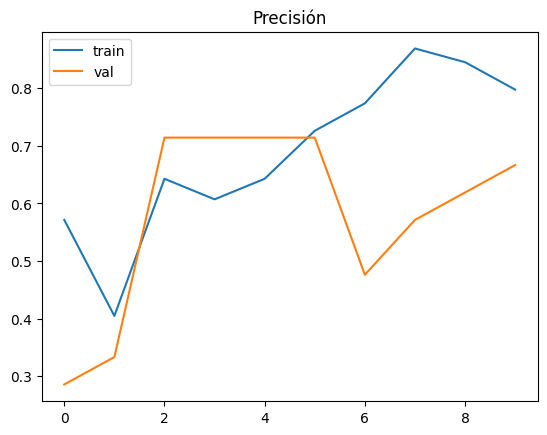

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step - accuracy: 0.7143 - loss: 0.6140
Precisión validación: 71.43%


In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Precisión'); plt.legend(); plt.show()

val_loss, val_acc = model.evaluate(val_gen)
print(f"Precisión validación: {val_acc:.2%}")

**Conclusion**

Como se observa en el gráfico actualizado, la precisión de validación aumentó significativamente, alcanzando un 71.43 %, y el modelo muestra una evolución mucho más estable tanto en entrenamiento como en validación. Esto indica que el modelo está aprendiendo a distinguir mejor las clases, reduciendo el sobreajuste y mejorando su capacidad de generalización.

La ampliación y mejora del dataset, junto con la reutilización de un modelo previamente entrenado (transfer learning), permitió obtener resultados más robustos y adecuados para la tarea de detección de posturas. Este enfoque valida el uso de CNN y reentrenamiento como estrategia eficaz en problemas reales de visión por computadora.